### CEG 4900 Trustworthy Machine Learning - Lab Assignment 3

# <center>Adversarial Reprogramming and Privacy Attacks</center>

### 1. Overview
The learning objective of this lab assignment is for students to understand adversarial reprogramming and privacy attacks, including how to adversarially reprogram a pretrained model to perform malware detection, and how to leverage model output probability distribution difference between training data and unseen data to perform membership inference attack.

#### Lecture notes. 
Detailed coverage of these topics can be found in the following:
<li>Adversary for Social Good</li>
<li>Privacy Attacks</li>

#### Code demonstrations.
<li>Code-Adversarial Reprogramming.ipynb</li>
<li>Code-Membership Inference Attack.ipynb</li>

### 2. Submission
You need to submit a detailed lab report with code, running results, and answers to the questions. If you submit <font color='red'>a jupyter notebook (“Firstname-Lastname-4900-Lab3.ipynb”)</font>, please fill in this file directly and place the code, running results, and answers in order for each question. If you submit <font color='red'>a PDF report (“Firstname-Lastname-4900-Lab3.pdf”) with code file (“Firstname-Lastname-4900-Lab3.py”)</font>, please include the screenshots (code and running results) with answers for each question in the report.  

### 3. Questions (50 points)

#### Preparations: import the required libraries and define functions

Please run the following cell to import all the required libraries and define some necessary functions before complete the coding questions.

In [23]:
#Put all the libraries here
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset, Dataset

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import math
import pandas as pd

#Set the random seed
np.random.seed(42)
torch.manual_seed(42)

#Define the training function for training model using train_dataloader
def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()
    
    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0 
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        #Get the predicted output
        predictions = model(X_batch)

        #Calculate the loss
        loss = lossfunction(predictions, y_batch)
        
        #Update the weights usning gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()
        
        #Convert probabilities to multi-class predictions (reutrn the class with the maximal proability)
        _, train_predicted = torch.max(predictions.data, 1)
        
        #Calculate the training statistics
        train_loss += loss.item()
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))

#Define the test function for evaluating the trained model using test_dataloader
def test(model, test_dataloader):
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            
            _, test_predicted = torch.max(predictions.data, 1)
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, macro_f1))

#Define the class to convert the data to the Pytorch tensors
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        label = np.array(label)
        return [torch.from_numpy(image).float(), torch.from_numpy(label).long()]

#Define make_member_nonmember() to obtain member_set and non_member_set for a given shadow model
def make_member_nonmember(shadow_model, shadow_features, unseen_features):
    probs = shadow_model.predict_proba(shadow_features)
    member_set = probs

    probs = shadow_model.predict_proba(unseen_features)
    non_member_set = probs
        
    return member_set, non_member_set

## <font color='blue'>Adversarial Reprogramming</font>

#### Load and preprocess the `Android dataset` data

In Question 1 and Question 2, you will be using the `Android dataset` to train an adversarial reprogramming model for Android malware detection that predicts if an application (app) is a benign app or malicious app. First, please place `android.csv` and your notebook/python file in the same directory, and load and preprocess the data.

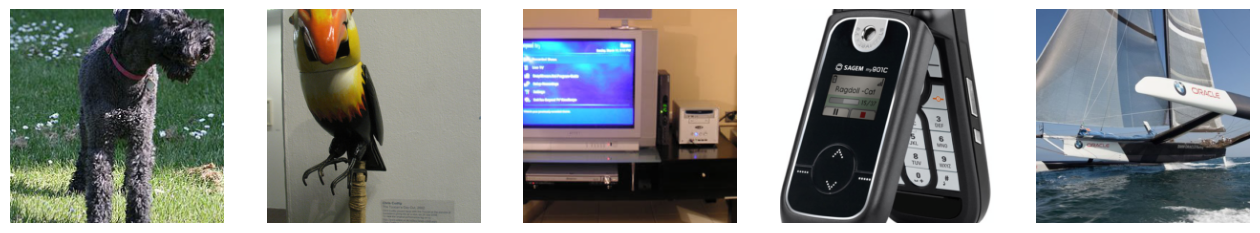

In [24]:
#Please place ImageNet_images.npy, android.csv and your notebook/python file in the same directory; otherwise, change DATA_PATH 
DATA_PATH = ""

#Load 5 images from ImageNet
image_path = os.path.join(DATA_PATH, "ImageNet_images.npy")
host_images = np.load(image_path)

#Plot the data
def plot_digits(instances, images_per_row=5):
    for i in range(len(instances)):
        idx = i % images_per_row
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = np.transpose(instances[i], (1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax[idx].imshow(image)
        ax[idx].axis("off")

fig, ax = plt.subplots(1, 5, figsize=(16, 8))
plot_digits(host_images, images_per_row=5)
plt.show()

def load_android_data(csv_path=DATA_PATH):
    csv_path = os.path.join(csv_path, "android.csv")
    return pd.read_csv(csv_path)

android = load_android_data()

#Divide the data frame into features and labels
android_labels = android["label"].copy() # use "label" as classification label: malicious (1) or benign (0)
android_features = android.drop("label", axis=1) # use API columns other than "label" as features

#Scale the features
std_scaler  = StandardScaler()
android_features_scaled = std_scaler.fit_transform(android_features)

#Feature names include API1 - API329
features = android_features_scaled

#labels - 0: benign; 1: malicious
labels = android_labels.astype(np.int64).to_numpy()
label_names = ['Benign', 'Malicious']

**Select subset of Android app samples and pre-train a logistic regression model from scratch for Android malware detection**

In this task, you will focus on performing adversarial reprogramming for Android malware detection and compare it with a logistic regression model trained from scratch; therefore, this logistic regression model is given as follows.

In [25]:
np.random.seed(1)

#Due to limited computing resources, assign a small value to the variable subset_size
subset_size = 100
sample_indices = np.random.choice(len(labels), subset_size, replace=False)

#Choose a subset of data for model training
X = features[sample_indices]
y = labels[sample_indices]

#Data splits for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=42)

print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#Pre-train a logistic regression for Android malware detection
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("Android malware detection using a model trained from scratch - Accuracy: %.4f, F1_score: %.4f" % (accuracy, f1))

(100, 329)
(100,)
(20, 329)
(20,)
(80, 329)
(80,)
Android malware detection using a model trained from scratch - Accuracy: 0.6750, F1_score: 0.6577


#### Question 1 (10 points):  

**Implement an adversarial reprogramming model to reprogram a high-performing pretrained ImageNet neual network to change the original image classification task to perform malware detection task, such that the detection performance can be improved over a small training dataset.**

**First, define `InputTransformation` to embed the features from apps into the host image, and then implement the function `answer_one( )` to perform input transformation and obtain data loaders for adversarial reprogramming training and testing.**

In [26]:
np.random.seed(42)

#App feature size
feature_size = X_train.shape[1]

#5 ImageNet images have been loaded from "ImageNet_images.npy"
#Here assign 0 to the index to use the first ImageNet image
index = 0
host_image = host_images[index]

#After adding the app features into the host image, perturbation needs to be added to the host image as well
#To avoid the pixels that have been used to store app features from being perturbed
#Here a mask is generated to protect these pixels
mask = np.ones_like(host_image)
mask = mask.reshape(3 * 224 * 224)
#Embed the features into the pixels randomly selected from all the pixels
indices = np.random.choice(3 * 224 * 224, feature_size, replace=False)
mask[indices] = 0
mask = mask.reshape((3, 224, 224))


#Define a clsss to perform input transformation
class InputTransformation(Dataset):
    def __init__(self, features, labels, host_image, mask, indices, feature_size, transform=None):
        #Code here: initialize the variables used in the class
        self.features = features
        self.labels = labels
        self.host_image = host_image
        self.indices = indices
        self.feature_size = feature_size
        self.transform = transform
        self.mask = mask
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = self.features[idx]
        label = self.labels[idx]
        host_image = self.host_image.copy()
        
        #Code here: embed the features of each app into the pixels of the host image specified by self.indices  
        host_image = host_image.reshape(3 * 224 * 224)
        host_image[self.indices] = features
        host_image = host_image.reshape((3, 224, 224))
        
        #Construct the transformed new input sample
        sample = {'image': host_image, 'label': label}

        if self.transform:
            #Convert the data into PyTorch tensor
            sample = self.transform(sample)

        return sample

    
def answer_one():
    #Code here: construct train_dataset by invoking InputTransformation()
    #You need to pass the corresponding parameters to InputTransformation()
    #Here, features should be X_train, and labels should be y_train  
    train_dataset = InputTransformation(features=X_train,
                                        labels=y_train,
                                        host_image=host_image,
                                        mask=mask,
                                        indices=indices,
                                        feature_size=feature_size,
                                        transform=transforms.Compose([
                                            ToTensor()
                                        ]))
    
    #Code here: load train_dataset into train_dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    
    #Code here: construct test_dataset by invoking InputTransformation()
    #You need to pass the corresponding parameters to InputTransformation()
    #Here, features should be X_test, and labels should be y_test 
    test_dataset = InputTransformation(features=X_test,
                                       labels=y_test,
                                       host_image=host_image,
                                       mask=mask,
                                       indices=indices,
                                       feature_size=feature_size,
                                       transform=transforms.Compose([
                                           ToTensor()
                                       ]))
    
    #Code here: load test_dataset into test_dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
    
    return train_dataloader, test_dataloader

#Run your function in the cell to return the results
train_dataloader, test_dataloader = answer_one()

#### <font color='red'>Answer 1 (double click here to answer the questions in this cell):</font>  
Based on the implemented steps in this question, please briefly summarize why the input transformation is necessary for reprogramming pretrained ImageNet neural network: (Input Transformation is necessary for reprogramming the pretrained ImageNet neural network because it allows for the features of the new task, in this case malware detection, to be embedded into the input space of the pretrained model, in this case image classification. This allows the pretrained model to be able to process the transformed inputs while also preserving its learned capabilities. This allows it to adapt to the new task, without the need of retraining the entire network each time. )

#### Question 2 (10 points):  

**First, define `AdversarialReprogrammingNet` to perform adversarial reprogramming, and then implement the function `answer_two( )` to train the adversarial reprogramming model and evaluate its performance for malware detection, which reads in the transformed inputs (i.e., images with app features), adds perturbation into the inputs, calculates the image classification results using the pretrained ImageNet neural network, and maps these image classfication results (1,000 classes) to the malware detection results (either benign or malicious).** 

In [27]:
#Set up hyperparameters
torch.manual_seed(1)
epochs = 5
learning_rate = 0.001
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

#Here, densenet161 is loaded as the pretrained ImageNet neural network
#The pretrained model won't be updated during adversarial reprogramming
#So requires_grad for all layers is set as False
pretrained_model = models.densenet161(pretrained=True)
pretrained_model.eval()
for param in pretrained_model.parameters():
    param.requires_grad = False

    
#Define a clsss to perform adversarial reprogramming
class AdversarialReprogrammingNet(nn.Module):
    def __init__(self, mask, pretrained_model):
        super(AdversarialReprogrammingNet, self).__init__()
        #Code here: randomly select two unique indices from [0, 999] to predict benign and malicious respectively
        self.hard_coded_idx = [0, 999]
        #Code here: set up the pretrained model
        self.pretrained_model = pretrained_model
        #Code here: create a 3x224x224-dimensional perturbation tensor and add it to the model parameter for updating
        #Note: requires_grad needs to be True
        self.perturbation = Parameter(torch.FloatTensor(3, 224, 224), requires_grad=True)
        self.reset_parameter()
        
        #Set up mask tensor
        self.mask = torch.FloatTensor(mask)
    
    def reset_parameter(self):
        stdv = 1. / math.sqrt(self.perturbation.size(1))
        self.perturbation.data.uniform_(-stdv, stdv)
    
    def forward(self, x):
        #Code here: multiply perturbation with mask and add it to the input x
        x = x + self.perturbation * self.mask
        #Code here: feed the perturbed x to the pretrained model to get image classification results 
        x = self.pretrained_model(x)
        #Code here: map the classification results to the malware detection results using hard-coded mapping
        y = x[:, self.hard_coded_idx]
        
        return y
    

def answer_two():
    #Code here: instantiate an adversarial reprogramming model from AdversarialReprogrammingNet (need to pass two parameters)
    adversarial_reprogramming_model = AdversarialReprogrammingNet(mask, pretrained_model)
    
    #Collect the model paramters to update
    parameter_to_update = []
    for p in adversarial_reprogramming_model.parameters():
        if p.requires_grad:
            parameter_to_update.append(p)
            break
    
    #Code here: specify the optimizer used for gradient descent for adversarial reprogramming model training
    adversarial_reprogramming_optimizer = optim.Adam(parameter_to_update, lr=learning_rate, weight_decay=weight_decay)
    
    print("-------Train the adversarial reprogramming model-------")
    for epoch in range(1, epochs + 1):
        #Code here: call train() function (need to pass 5 parameters)
        train(epoch, adversarial_reprogramming_model, train_dataloader, adversarial_reprogramming_optimizer, lossfunction)
    
    print("-------Test the adversarial reprogramming model-------")
    #Code here: call test() function (need to pass 2 parameters)
    test(adversarial_reprogramming_model, test_dataloader)

#Run your function in the cell to return the results
answer_two()

c:\Users\josep\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\josep\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-------Train the adversarial reprogramming model-------
epoch (1): Train accuracy: 0.5500, loss: 0.190
epoch (2): Train accuracy: 0.9000, loss: 0.105
epoch (3): Train accuracy: 0.7000, loss: 0.154
epoch (4): Train accuracy: 0.9500, loss: 0.066
epoch (5): Train accuracy: 0.9500, loss: 0.035
-------Test the adversarial reprogramming model-------
Test accuracy: 0.7000, macro f1_score: 0.6875


#### <font color='red'>Answer 2 (double click here to answer the questions in this cell):</font>  
In this question, only 20 training samples are used for malware detection model training<br>
When training a logistic regression from scratch, the test accuracy is: (0.6750 ) <br>
When training an adversarial reprogranmming model, the test accuracy is: (0.700 ) <br>
Comparing these test performances, please describe your observation: (The trained adversarial reprogramming model has a higher test accuracy than the trained logistic regression model from scratch. ) <br>
And explain why adversarial reprogramming can deliver such a performance difference: (The adversarial reprogramming model is able to deliver such a performance difference because it reprograms the ImageNet classification model that is able to help in detecting fraud, leading to an increase in accuracy. )

## <font color='blue'>Membership Inference Attack</font>

In Question 3, Question 4, and Question 5, you will continue using the `Android dataset` to perform membership inference attack.

#### Prepare Datasets and train a target model

For the membership inference attack introduced in class, the first step is to synthesize a dataset to train a shadow model. Here, instead of sythesizing the dataset, you will sample this dataset directly from the loaded data (`features`, `labels`) and focus on the second step that trains a set of shadow models to collect member and non-member confidence scores and construct attack model.

We also train a logistic regression model here as the target model. After this target model is trained, a membership inference attack will be built to infer if a record is used to train this target model or not.

In [28]:
np.random.seed(42)
torch.manual_seed(42)

#Data splits: (M_X_train, M_y_train) for target model, and (M_X_test, M_y_test) for shadow models
M_X_train, M_X_test, M_y_train, M_y_test = train_test_split(features, labels, test_size=0.50, random_state=42)

#The number of shadow models
num_shadow_models = 10

#The size of samples for each shadow model
shadow_size = 200

#List of training datasets: each training set is used to train one shadow model
list_shadow_features = []
list_shadow_labels = []
#List of Unseen datasets: one for each shadow model
list_unseen_features = []

for _ in range(num_shadow_models):
    #training data and unseen data should be disjoint
    #Obtain the indices for training data and unseen data
    train_indices = np.random.choice(len(M_X_test), shadow_size, replace=False)
    remaining_indices = np.setdiff1d(np.arange(len(M_X_test)), train_indices)
    unseen_indices = np.random.choice(remaining_indices, shadow_size, replace=False)
    
    subset_train_features = M_X_test[train_indices]
    subset_train_labels = M_y_test[train_indices]
    subset_unseen_features = M_X_test[unseen_indices]
    
    list_shadow_features.append(subset_train_features)
    list_shadow_labels.append(subset_train_labels)
    list_unseen_features.append(subset_unseen_features)

#Train a target model
target_model = LogisticRegression(solver="newton-cg", random_state=42)
target_model.fit(M_X_train, M_y_train)

LogisticRegression(random_state=42, solver='newton-cg')

#### Question 3 (10 points):  

**Implement the function `answer_three( )` to collect `total_members` and `total_non_members` for attack model training, where `total_members` are confidence scores of samples used by shadow model training, and `total_non_members` are confidence scores of samples unseen to shadow models. You can use the pre-defined function `make_member_nonmember( )` to obtain `member_set` and `non_member_set` for a given shadow model. Please train a set of shadow models to aggregate all these data sets.**

In [29]:
def answer_three():    
    total_members = []
    total_non_members = []
    
    for shadow_number, shadow_features in enumerate(list_shadow_features):
        print("-----------Shadow model: {}-----------".format(shadow_number + 1))
        shadow_labels = list_shadow_labels[shadow_number]
        unseen_features = list_unseen_features[shadow_number]
        
        #Code here: create a shadow model using LogisticRegression with solver="newton-cg", random_state=42
        shadow_model = LogisticRegression(solver="newton-cg", random_state=42)
        #Code here: use shadow_features and shadow_labels to fit a shadow model
        shadow_model.fit(shadow_features, shadow_labels)
        
        #Code here: call make_member_nonmember() to create member_set vs non_member_set based on shadow_model
        #The model should be shadow_model, member_set should be from shadow_features and non_member_set should be from unseen_features
        member_set, non_member_set = make_member_nonmember(shadow_model, shadow_features, unseen_features)
        
        total_members.append(member_set)
        total_non_members.append(non_member_set)
    
    #Code here: use np.concatenate to join the sequence of arrays from total_members 
    total_members = np.concatenate(total_members)
    #Code here: use np.concatenate to join the sequence of arrays from total_non_members
    total_non_members = np.concatenate(total_non_members)
    
    return total_members, total_non_members

#Run your function in the cell to return the results
total_members, total_non_members = answer_three()

-----------Shadow model: 1-----------
-----------Shadow model: 2-----------
-----------Shadow model: 3-----------
-----------Shadow model: 4-----------
-----------Shadow model: 5-----------
-----------Shadow model: 6-----------
-----------Shadow model: 7-----------
-----------Shadow model: 8-----------
-----------Shadow model: 9-----------
-----------Shadow model: 10-----------


#### <font color='red'>Answer 3 (double click here to answer the questions in this cell):</font>  
Based on the implemented steps in this question, please briefly summarize the difference between member sets and non-member sets: (The difference between members sets and non-member sets is taht member sets have confidence scores for samples that were in the training data for the shadow model, whereas non-member sets have confidence scores for samples that are not seen by the shadow model during training. ), and why this difference exists (This difference exists because shadow models are able to be more confident in predicting the labels of the training data for member sets due to memorization, whereas unseen data in non-member sets the model will exhibit lower confidence in its predictions. )

#### Question 4 (10 points): 

**Implement the function `answer_four( )` to train a binary classification model as membership inference attack model using `total_members` and `total_non_members`, and evaluate its attack performance.**

In [30]:
def answer_four():
    #Obtain the sample size in total_members and total_non_members
    total_members_size = total_members.shape[0]
    total_non_members_size = total_non_members.shape[0]
    
    #Generate labels: member - 1 and non-member - 0 with total_members_size and total_non_members_size
    #Code here: use np.repeat() with parameters: 1 and total_members_size
    total_members_labels = np.repeat(1, total_members_size)
    #Code here: use np.repeat() with parameters: 0 and total_non_members_size
    total_non_members_labels = np.repeat(0, total_non_members_size)
    
    #Concatenate total_members and total_non_members to construct final data for attack model training
    #Code here: use np.concatenate() to join (total_members, total_non_members) to construct X_attack
    X_attack = np.concatenate((total_members, total_non_members))
    #Code here: use np.concatenate() to join (total_members_labels, total_non_members_labels) to construct y_attack
    y_attack = np.concatenate((total_members_labels, total_non_members_labels))
    
    #Code here: use train_test_split to split data (X_attack, y_attack) to training data for attack model training and test data for attack model evaluation 
    #Note: use test_size=0.20, random_state=42
    X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X_attack, y_attack, test_size=0.20, random_state=42)
    
    #Code here: train attack_model using LogisticRegression with solver="newton-cg", random_state=42
    attack_model = LogisticRegression(solver="newton-cg", random_state=42)
    #Code here: use X_attack_train and y_attack_train to fit this attack_model
    attack_model.fit(X_attack_train, y_attack_train)
    
    #Code here: use attack_model to predict the membership of X_attack_test
    y_attack_pred = attack_model.predict(X_attack_test)
    
    #Code here: calculate accuracy and macro f1-score between y_attack_test and y_attack_pred
    accuracy = accuracy_score(y_attack_test, y_attack_pred)
    f1 = f1_score(y_attack_test, y_attack_pred, average='macro')
    
    return accuracy, f1, attack_model

#Run your function in the cell to return the results
accuracy, f1, attack_model = answer_four()
print("Accuracy: %.4f, F1_score: %.4f" % (accuracy, f1))

Accuracy: 0.5288, F1_score: 0.5287


#### <font color='red'>Answer 4 (double click here to answer the questions in this cell):</font>  
When training a binary classification model to perform membership inference attack on the shadow models: <br>
the test accuracy is: (0.5288 ) <br>
the f1-score is: (0.5287 )

#### Question 5 (10 points): 

**Implement the function `answer_five( )` to use the trained attack model `attack_model` to perform membership inference attack over the target model `target_model`. In Question 4, `attack_model` is only evaluated on the dataset generated from the shadow models, but in the real-world setting, this attack model needs to be applied to infer the membership of a black-box `target_model`. As `target_model` is trained on `M_X_train`, you can feed `M_X_train` to `target_model` to collect probability outputs as member set; as `M_X_test` is unseen to `target_model`, then you can feed `M_X_test` to `target_model` to collect propability outputs as non-member set.**

In [34]:
def answer_five():
    #Code here: call make_member_nonmember() to create member_set vs non_member_set based on target_model
    #The model should be target_model, member_set should be from M_X_train and non_member_set should be from M_X_test
    member_set, non_member_set = make_member_nonmember(target_model, M_X_train, M_X_test)
    
    #Obtain the sample size in member_set and non_member_set
    members_size = member_set.shape[0]
    non_members_size = non_member_set.shape[0]
    
    #Generate labels: member - 1 and non-member - 0 with members_size and non_members_size
    #Code here: use np.repeat() with parameters: 1 and members_size
    members_labels = np.repeat(1, members_size)
    #Code here: use np.repeat() with parameters: 0 and non_members_size
    non_members_labels = np.repeat(0, non_members_size)
    
    #Concatenate member_set and non_member_set to construct final data for membership inference over target_model
    #Code here: use np.concatenate() to join (member_set, non_member_set) to construct X_membership
    X_membership = np.concatenate((member_set, non_member_set))
    #Code here: use np.concatenate() to join (members_labels, non_members_labels) to construct y_membership
    y_membership = np.concatenate((members_labels, non_members_labels))
    
    #Code here: use attack_model to predict the membership of X_membership
    y_pred_membership = attack_model.predict(X_membership)
    
    #Code here: calculate accuracy and macro f1-score between y_membership and y_pred_membership
    accuracy = accuracy_score(y_membership, y_pred_membership)
    f1 = f1_score(y_membership, y_pred_membership, average='macro')
    
    return accuracy, f1

#Run your function in the cell to return the results
accuracy, f1 = answer_five()
print("Accuracy: %.4f, F1_score: %.4f" % (accuracy, f1))

Accuracy: 0.5072, F1_score: 0.5064


#### <font color='red'>Answer 5 (double click here to answer the questions in this cell):</font>  
When using the attack model trained on the data collected from shadow models to perform membership inference attack over the target model: <br>
the test accuracy is: (0.5072 ) and the f1-score is: (0.5064 ) <br>
Comparing the attack performances in Question 4 and 5, please describe your observation: (The attack performances between Question 4 and 5 are that in Question 4, the test accuracy and f1 score is slightly higher than that of the results from Question 5. ) <br>
And explain why this difference exists: (This difference exists because the attack model in Question 4 is trained on data generated from shadow models, whereas in Question 5, the model is applied to a non-shadow target model, which has different behaviors than the shadow model from Question 4. This results in a small drop in performance.)